In [7]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

#import crocosi.postp as pp
#from crocosi.jet import set_relevant_time
import phdequinox.croco_drifter as cdr

In [2]:
from dask.distributed import Client, LocalCluster
#cluster = LocalCluster()
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(jobs=4)

In [3]:
from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster

In [4]:
client

Client Scheduler: tcp://10.148.0.233:56238 Dashboard: http://10.148.0.233:8787/status,Cluster Workers: 14 Cores: 14 Memory: 239.96 GB


In [8]:
root_path = '/home/datawork-lops-osi/equinox/jetn/old/'
#root_path = '/home1/datawork/slgentil/'#jet_cfg1_wp75_4km_1500a2000j_floats_lev50
run = 'jet_cfg1_wp75_4km_1500a2000j_itide/'

## Presentation simulation

In [6]:
eulerian_field = xr.open_dataset(root_path+run+'diagnostics/Eulerian_field_ZC.nc').persist()

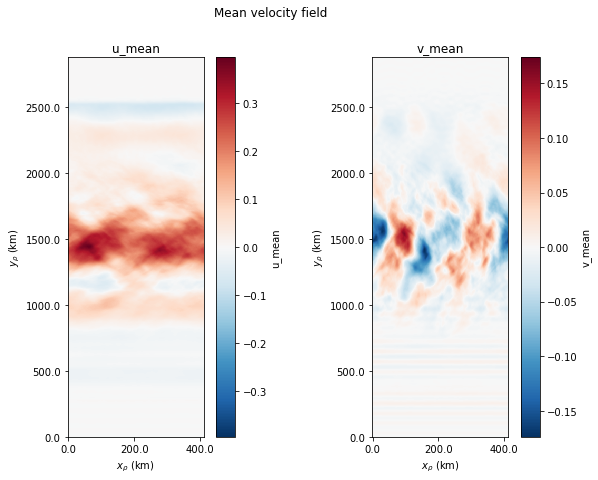

In [7]:
fig,axs = plt.subplots(1,2,figsize=(10,7))
for V,ax in zip(['u_mean','v_mean'],axs):
    eulerian_field[V].plot(ax=ax)#,cbar_kwargs={'label':r'$%s$'%V})
    ax.set_aspect('equal');fig.suptitle('Mean velocity field')
    labx,laby = ax.get_xticks(),ax.get_yticks();labx,laby = [str(l*1e-3) for l in labx],[str(l*1e-3) for l in laby];
    ax.set_xticklabels(labx);ax.set_yticklabels(laby)
    ax.set_ylabel(r'$y_\rho$ (km)');ax.set_xlabel(r'$x_\rho$ (km)')
    ax.set_title(V)

### Lagrangian

In [5]:
dr = cdr.drifter_dataframe(root_path+run,parquet=True,index='id',persist=False)
dr

         time      xgrid      ygrid  zgrid     depth       temp         u  \
id                                                                          
1   1514.4167  25.897255  174.72748   50.0  0.870458  24.579730 -0.000864   
1   1508.3056  26.356433  168.51951   50.0  0.763907  24.579722  0.059964   
1   1508.2986  26.348080  168.48829   50.0  0.764288  24.579721  0.054308   
1   1508.2917  26.340585  168.45690   50.0  0.764393  24.579721  0.048543   
1   1508.2847  26.333961  168.42548   50.0  0.764202  24.579721  0.042720   

           v      dudt          dvdt      pres           x          y  
id                                                                     
1   0.089855  0.000009 -9.453702e-06  9.414380  103.589020  698.90992  
1   0.203875  0.000010 -4.799399e-06  8.369084  105.425732  674.07804  
1   0.207708  0.000010 -3.143696e-06  8.372827  105.392320  673.95316  
1   0.209148  0.000010 -1.401524e-06  8.373855  105.362340  673.82760  
1   0.209600  0.000010  3.03

In [7]:
df_jet = dr.df.loc[119].compute()
df_north = dr.df.loc[255].compute()
df_south = dr.df.loc[7501].compute()

#### Eulerian

In [8]:
gparams = {'f0': 1.0313e-4, 'beta': 1.6186e-11}
r = pp.Run(root_path+run, prefix='', outputs=['surf','his'], verbose=False)
r['surf'] = r['surf'].rename({'time_instant': 'time'})

In [9]:
V = ['u', 'v','ssh']
dij = 1
dti = 1
ds = (r['surf'][V].isel({'x_rho': slice(0,None,dij), 'x_u': slice(0,None,dij),
                         'y_rho': slice(0,None,dij), 'y_v': slice(0,None,dij),
                         'time': slice(0,None,dti)})
     ).squeeze()
print('dataset size: %.0f GB' %(ds.nbytes/1e9))

dataset size: 161 GB


In [10]:
x,y,t = 'auto', 'auto' , 'auto'
ds = ds.chunk({'time': t, 'x_rho': x, 'x_u': x, 'y_rho': y, 'y_v': y})

In [12]:
#ds = ds.persist()
#ds

<xarray.Dataset>
Dimensions:       (time: 72000, x_rho: 258, x_u: 257, y_rho: 722, y_v: 721)
Coordinates:
    s_rho_slice0  float32 -0.01
    f_rho         (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
  * x_u           (x_u) float32 0.0 4000.0 8000.0 ... 1020000.0 1024000.0
    y_u           (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
  * y_v           (y_v) float32 0.0 4000.0 8000.0 ... 2876000.0 2880000.0
  * time          (time) float64 dask.array<chunksize=(72000,), meta=np.ndarray>
    time_counter  (time) float64 1.5e+03 1.5e+03 1.5e+03 ... 2e+03 2e+03 2e+03
  * y_rho         (y_rho) float32 -2000.0 2000.0 6000.0 ... 2878000.0 2882000.0
    x_v           (x_rho) float32 dask.array<chunksize=(258,), meta=np.ndarray>
    f             (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
  * x_rho         (x_rho) float32 -2000.0 2000.0 6000.0 ... 1022000.0 1026000.0
Data variables:
    u             (time, y_rho, x_u) float32 dask.array<chunksize=(72000, 722, 257), meta=np.ndarray>
    v             (time, y_v, x_rho) float32 dask.array<chunksize=(72000, 721, 258), meta=np.ndarray>
    ssh           (time, y_rho, x_rho) float32 dask.array<chunksize=(72000, 722, 258), meta=np.ndarray>
Attributes:
    name:         surf
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2020-Feb-03 10:28:55 GMT
    uuid:         979d973b-3250-4199-96c2-7dff8e4f5076

In [11]:
t0 = 1550
t1 = 1565
tmid = (t0+t1)/2
imid = (tmid-1500)*24*6

In [17]:
df = df.set_index('time').persist()

In [19]:
df.loc[1557]

,id,xgrid,ygrid,zgrid,depth,temp,u,v,dudt,dvdt,pres,x,y
npartitions=1,,,,,,,,,,,,,
1557,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1557,...,...,...,...,...,...,...,...,...,...,...,...,...


In [20]:
#df = dr.df.loc[225].compute()
dsi = ds.u.isel(time=57*24*6).persist()

In [27]:
dfx = (df.x.loc[1557.5]*1e3).compute()
dfy = (df.y.loc[1557.5]*1e3).compute()

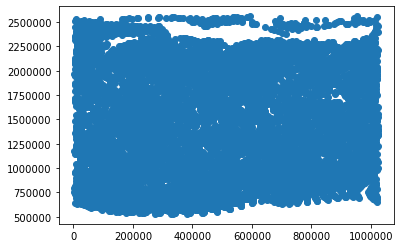

In [31]:
plt.scatter(dfx,dfy)

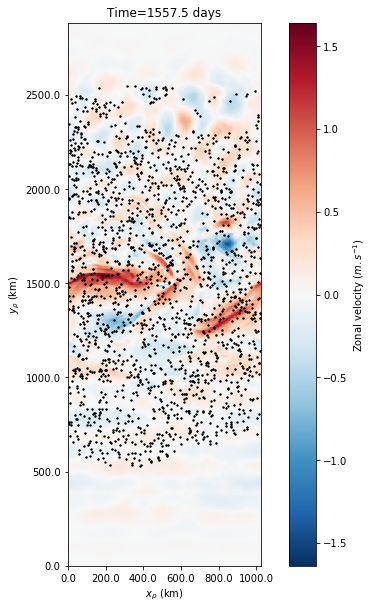

In [38]:
fig,ax = plt.subplots(figsize=(10,10))
dsi.plot(ax=ax,cbar_kwargs={'label':r'Zonal velocity ($m.s^{-1}$)'})
labx,laby = ax.get_xticks(),ax.get_yticks();labx,laby = [str(l*1e-3) for l in labx],[str(l*1e-3) for l in laby];
ax.set_xticklabels(labx);ax.set_yticklabels(laby)
ax.set_ylabel(r'$y_\rho$ (km)');ax.set_xlabel(r'$x_\rho$ (km)')
#ax.plot(df.x.loc[t0:t1]*1e3,df.y.loc[t0:t1]*1e3)
#ax.plot(df.x.loc[t0]*1e3,df.y.loc[t0]*1e3,marker='o',color='r',markeredgecolor='w');
#ax.plot(df.x.loc[tmid]*1e3,df.y.loc[tmid]*1e3,marker='d',color='b',markeredgecolor='w')
ax.scatter(dfx[::5],dfy[::5],s=2,c='k')
ax.set_aspect('equal')
ax.set_title('Time=%s days'%tmid)
fig.savefig('/home1/datawork/zcaspar/Figs/drifters_simu.png')

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


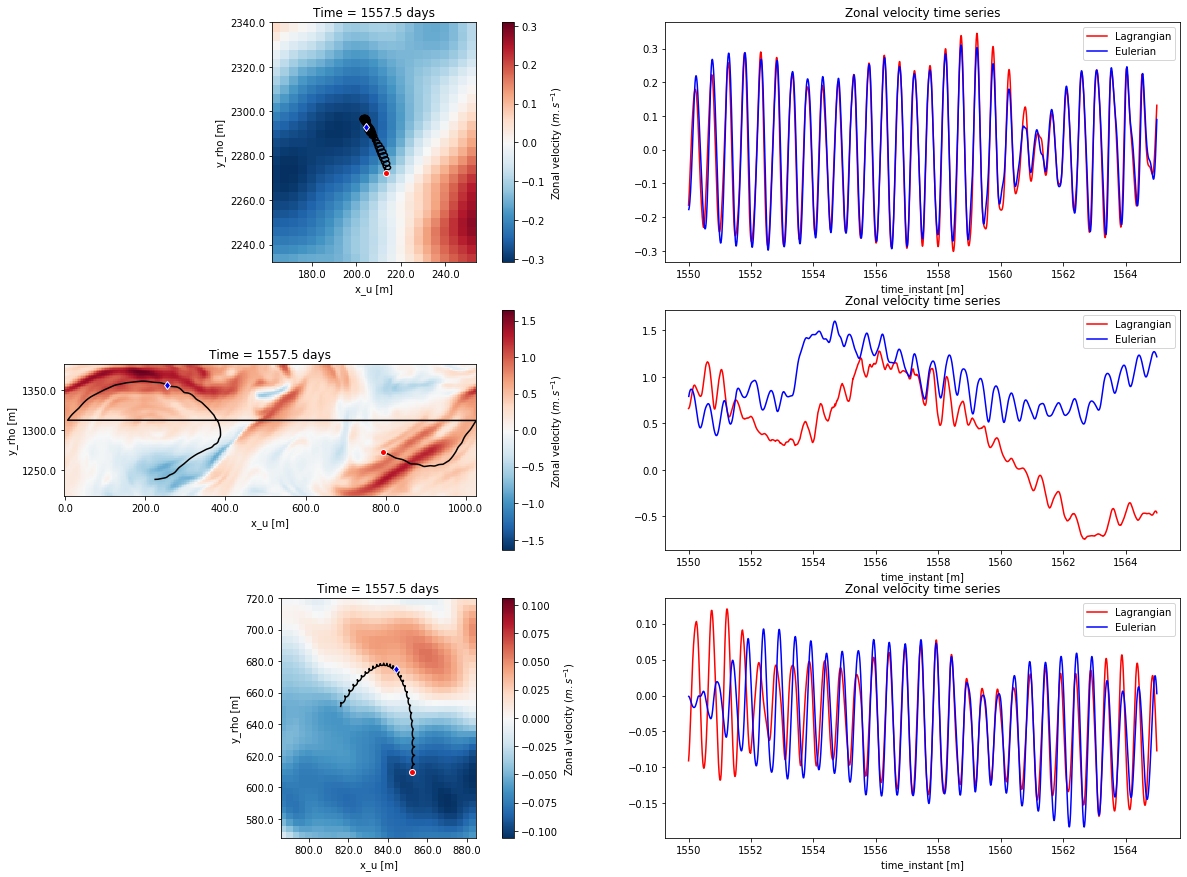

In [40]:
fig = plt.figure(figsize=(20,15))
grid = plt.GridSpec(3, 4, wspace=0.4, hspace=0.2)
for df,i in zip([df_north,df_jet,df_south],range(3)):
    df =df.sort_values('time').set_index('time')
    ds_zoom = ds.u.sel(x_u = slice((df.x.loc[t0:t1].min()-40)*1e3,(df.x.loc[t0:t1].max()+40)*1e3),
                       y_rho = slice((df.y.loc[t0:t1].min()-40)*1e3,(df.y.loc[t0:t1].max()+40)*1e3)).persist()
    #ds_zoom = ds_zoom.isel(time=57*24*6).compute()
    ax = plt.subplot(grid[i,:2])
    ds_zoom.isel(time=57*24*6).plot(ax=ax,cbar_kwargs={'label':r'Zonal velocity ($m.s^{-1}$)'})#.isel(time=57*24*6).plot(ax=ax)
    labx,laby = ax.get_xticks(),ax.get_yticks();labx,laby = [str(l*1e-3) for l in labx],[str(l*1e-3) for l in laby];
    ax.set_xticklabels(labx);ax.set_yticklabels(laby)
    ax.plot(df.x.loc[t0:t1]*1e3,df.y.loc[t0:t1]*1e3,'k')
    ax.plot(df.x.loc[t0]*1e3,df.y.loc[t0]*1e3,marker='o',color='r',markeredgecolor='w');
    ax.plot(df.x.loc[tmid]*1e3,df.y.loc[tmid]*1e3,marker='d',color='b',markeredgecolor='w')
    ax.set_aspect('equal');ax.set_title('Time = %s days'%tmid)
    ax=plt.subplot(grid[i,2:])
    df.u.loc[t0:t1].plot(ax=ax,c='r',label='Lagrangian')
    ds_zoom.sel(x_u=df.x.loc[tmid]*1e3,y_rho=df.y.loc[tmid]*1e3,method='nearest').isel(time=slice(50*24*6,65*24*6)).plot(ax=ax,label='Eulerian',c='b')
    ax.legend();ax.set_ylabel('');ax.set_title('Zonal velocity time series')
fig.tight_layout()

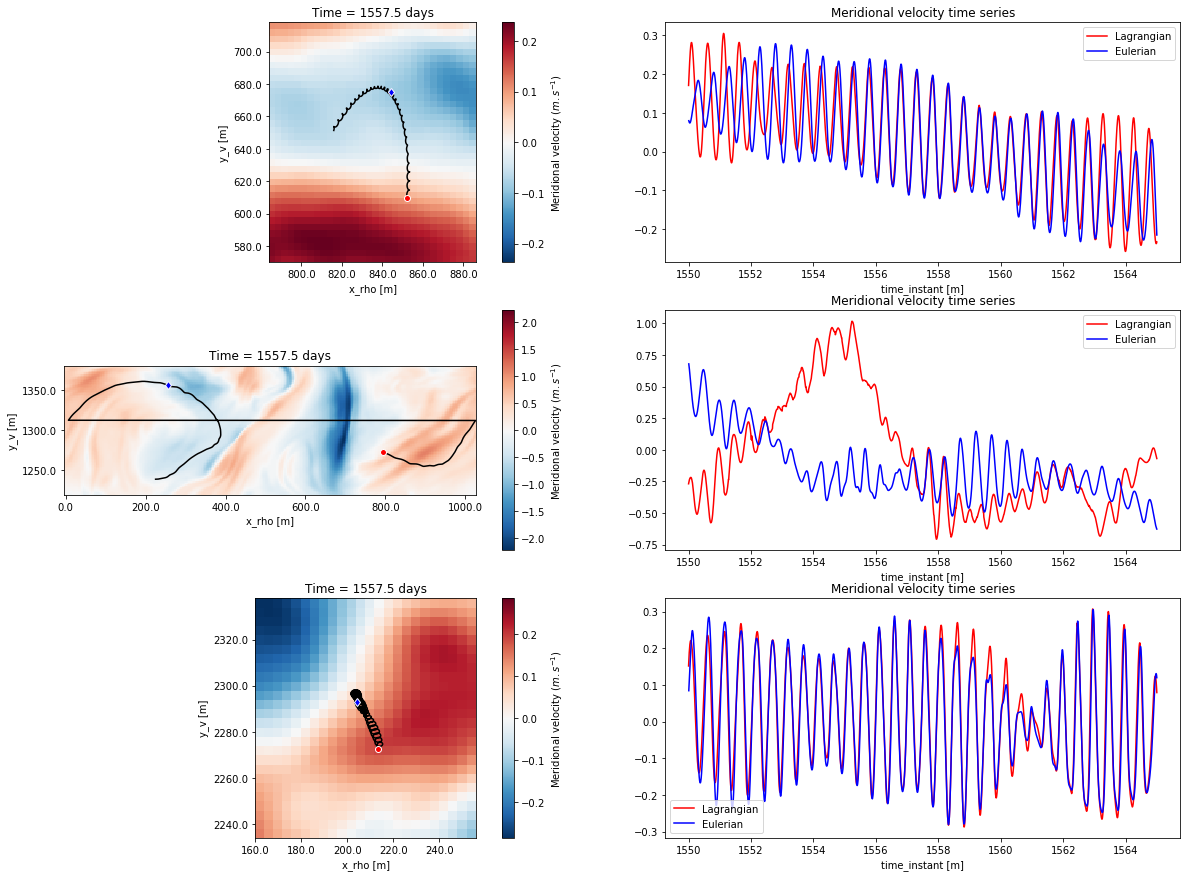

In [43]:
fig = plt.figure(figsize=(20,15))
grid = plt.GridSpec(3, 4, wspace=0.4, hspace=0.2)
for df,i in zip([df_south,df_jet,df_north],range(3)):
    df =df.sort_values('time').set_index('time')
    ds_zoom = ds.v.sel(x_rho = slice((df.x.loc[t0:t1].min()-40)*1e3,(df.x.loc[t0:t1].max()+40)*1e3),
                       y_v = slice((df.y.loc[t0:t1].min()-40)*1e3,(df.y.loc[t0:t1].max()+40)*1e3)).persist()
    #ds_zoom = ds_zoom.isel(time=57*24*6).compute()
    ax = plt.subplot(grid[i,:2])
    ds_zoom.isel(time=57*24*6).plot(ax=ax,cbar_kwargs={'label':r'Meridional velocity ($m.s^{-1}$)'})#.isel(time=57*24*6).plot(ax=ax)
    labx,laby = ax.get_xticks(),ax.get_yticks();labx,laby = [str(l*1e-3) for l in labx],[str(l*1e-3) for l in laby];
    ax.set_xticklabels(labx);ax.set_yticklabels(laby)
    ax.plot(df.x.loc[t0:t1]*1e3,df.y.loc[t0:t1]*1e3,'k')
    ax.plot(df.x.loc[t0]*1e3,df.y.loc[t0]*1e3,marker='o',color='r',markeredgecolor='w');
    ax.plot(df.x.loc[tmid]*1e3,df.y.loc[tmid]*1e3,marker='d',color='b',markeredgecolor='w')
    ax.set_aspect('equal');ax.set_title('Time = %s days'%tmid)
    ax=plt.subplot(grid[i,2:])
    df.v.loc[t0:t1].plot(ax=ax,c='r',label='Lagrangian')
    ds_zoom.sel(x_rho=df.x.loc[tmid]*1e3,y_v=df.y.loc[tmid]*1e3,method='nearest').isel(time=slice(50*24*6,65*24*6)).plot(ax=ax,label='Eulerian',c='b')
    ax.legend();ax.set_ylabel('');ax.set_title('Meridional velocity time series')

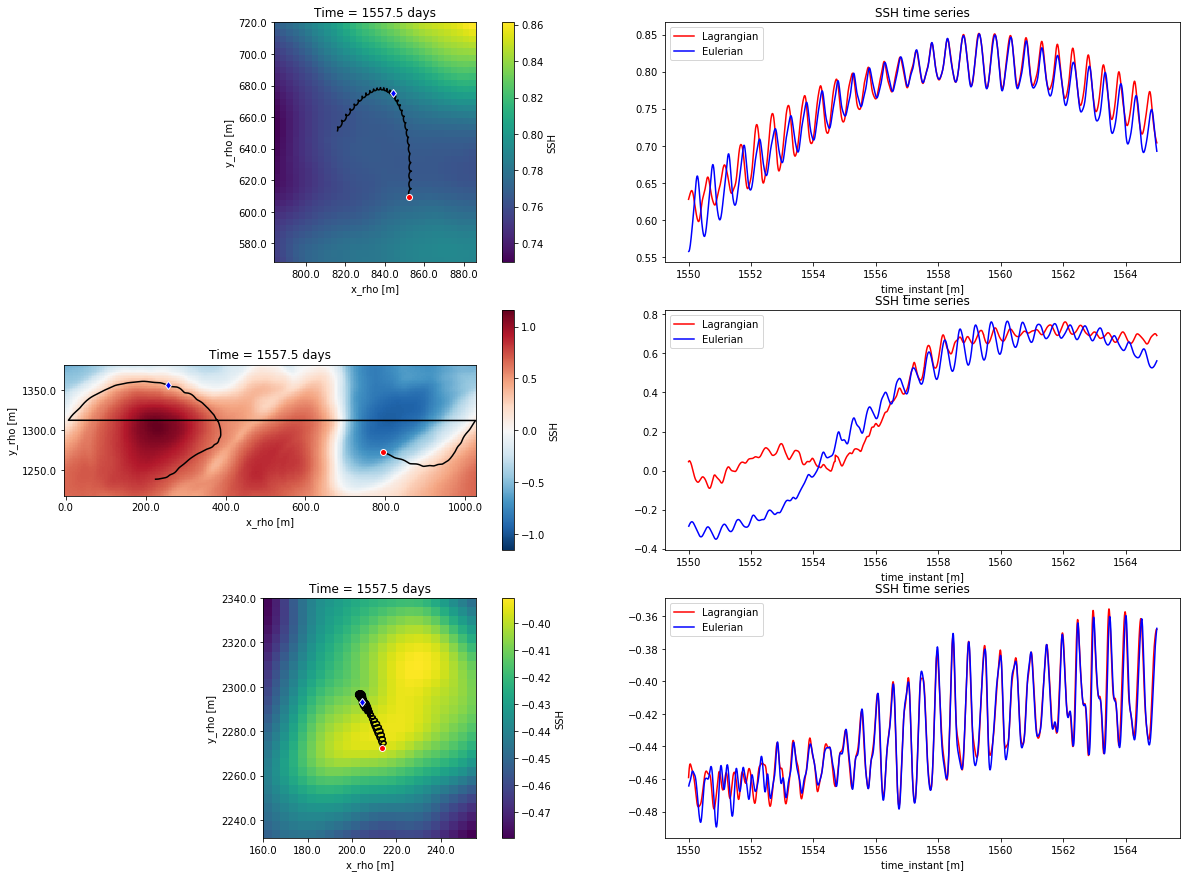

In [44]:
fig = plt.figure(figsize=(20,15))
grid = plt.GridSpec(3, 4, wspace=0.4, hspace=0.2)
for df,i in zip([df_south,df_jet,df_north],range(3)):
    df =df.sort_values('time').set_index('time')
    ds_zoom = ds.ssh.sel(x_rho = slice((df.x.loc[t0:t1].min()-40)*1e3,(df.x.loc[t0:t1].max()+40)*1e3),
                         y_rho = slice((df.y.loc[t0:t1].min()-40)*1e3,(df.y.loc[t0:t1].max()+40)*1e3)).persist()
    #ds_zoom = ds_zoom.isel(time=57*24*6).compute()
    ax = plt.subplot(grid[i,:2])
    ds_zoom.isel(time=57*24*6).plot(ax=ax,cbar_kwargs={'label':r'SSH'})#.isel(time=57*24*6).plot(ax=ax)
    labx,laby = ax.get_xticks(),ax.get_yticks();labx,laby = [str(l*1e-3) for l in labx],[str(l*1e-3) for l in laby];
    ax.set_xticklabels(labx);ax.set_yticklabels(laby)
    ax.plot(df.x.loc[t0:t1]*1e3,df.y.loc[t0:t1]*1e3,'k')
    ax.set_aspect('equal');ax.set_title('Time = %s days'%tmid)
    ax.plot(df.x.loc[t0]*1e3,df.y.loc[t0]*1e3,marker='o',color='r',markeredgecolor='w');
    ax.plot(df.x.loc[tmid]*1e3,df.y.loc[tmid]*1e3,marker='d',color='b',markeredgecolor='w')
    ax=plt.subplot(grid[i,2:])
    df.depth.loc[t0:t1].plot(ax=ax,c='r',label='Lagrangian')
    ds_zoom.sel(x_rho=df.x.loc[tmid]*1e3,y_rho=df.y.loc[tmid]*1e3,method='nearest').isel(time=slice(50*24*6,65*24*6)).plot(ax=ax,label='Eulerian',c='b')
    ax.legend();ax.set_ylabel('');ax.set_title('SSH time series')

In [6]:
def diags_dist(v1,v2,v3,v4,N):
#    fltI = flt.sel(time=slice(Ti,Tf))
    if v1 is None and v2 is None:
        return pd.Series(np.random.randn(N),index=['xmax','xmin','ymax','ymin','y0','y1','dx','dy','ds'])
    else : 
        dxint = np.abs(v3).mean()#np.diff(np.unwrap(v1)).sum()
        dyint = np.abs(v4).mean()#np.diff(v2).sum()
        dsint = np.sqrt(v3**2+v4**2).mean()#np.diff(np.unwrap(v1))**2+np.diff(v2)**2).sum()
        return pd.Series([np.unwrap(v1).max(),np.unwrap(v1).min(),v2.max(),v2.min(),v2.iloc[0],v2.iloc[-1],dxint,dyint,dsint],
                         index=['xmax','xmin','ymax','ymin','y0','y1','dx','dy','ds'])#,fltI.v

In [7]:
def apply_window(myfun,columns,T,N,L,binsize):
    """Compute diags_dist and returns xarray"""
    df_chunked = dr.df.groupby(dr.df.index).apply(cdr.time_window_processing, myfun, 
                                                  columns,T,N,L
                                                 )#.persist()
    y_bins = np.arange(0,2800,binsize)
    y_idx = pd.IntervalIndex.from_breaks(y_bins)
    df_chunked['y0_cut'] = df_chunked['y0'].map_partitions(pd.cut, bins=y_bins)
    df_chunked = (
              df_chunked.map_partitions(
                  lambda df: df.reset_index(level=[1]).rename(columns={'level_1': 'time'})
                                       )
              )
    # difference btw y max and min
    df_chunked['ydiff'] = df_chunked['ymax']-df_chunked['ymin']
    # difference btw x max and min
    df_chunked['xdiff'] = df_chunked['xmax']-df_chunked['xmin']
    DF = df_chunked.compute()
    return DF.set_index(DF.y0_cut.map(lambda v: v.mid)).drop(columns=['time','x','y']).rename(columns={'y0_cut':'y0_bins'}).to_xarray()

In [ ]:
ds_dist = {}
for T in [10,20,40,80,120]:
    ds_dist['ds_'+str(T)] = apply_window(diags_dist,['x','y','u','v'],T,9,1024,50)
#ds40 = apply_window(diags_dist,['x','y','u','v'],40,9,L,50)
#ds20 = apply_window(diags_dist,['x','y','u','v'],20,9,L,50)
#ds10 = apply_window(diags_dist,['x','y','u','v'],10,9,L,50)
#ds80 = apply_window(diags_dist,['x','y','u','v'],80,9,L,50)
#ds120 = apply_window(diags_dist,['x','y','u','v'],120,9,L,50)

In [10]:
ds_stats={}
for T in ['10','20','40','80','120']:
    ds_stats[T] = ds_dist['ds_'+str(T)].groupby('y0_cut').mean()
    ds_stats[T]['Tu'] = (float(T)*24*3600*ds_stats[T].dx*1e-3)
    ds_stats[T]['Tv'] = (float(T)*24*3600*ds_stats[T].dy*1e-3)

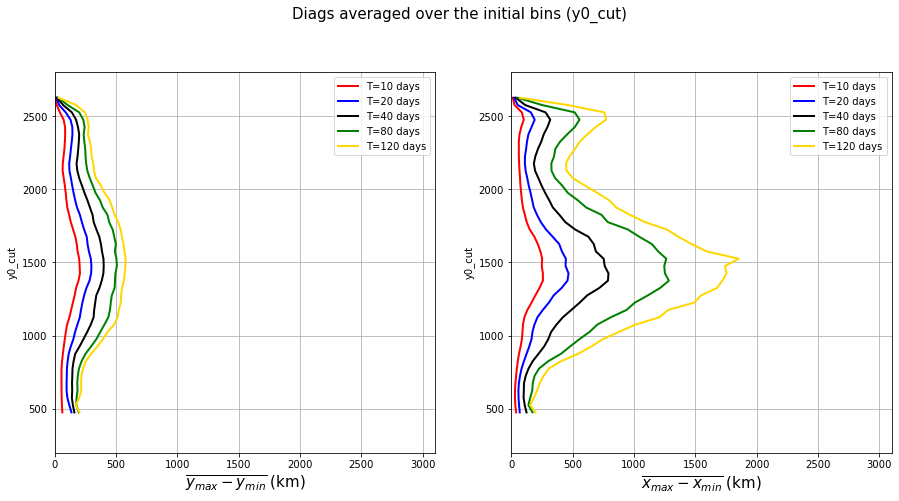

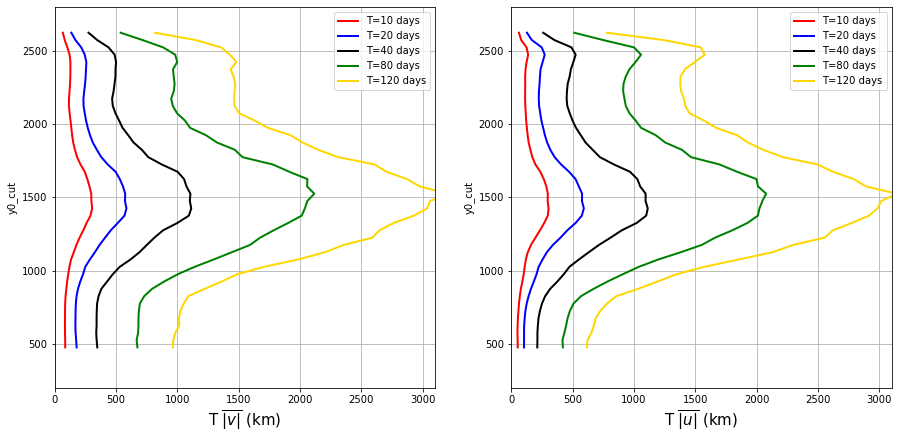

In [14]:
fontsize = 15
colors = ['r','b','k','g','gold']
fig,axs = plt.subplots(1,2,figsize=(15,7))
fig.suptitle('Diags averaged over the initial bins (y0_cut)',x=0.5,y=1.01,fontsize=fontsize)
for T,c in zip(ds_stats.keys(),colors):
    for var,lab,ax in zip(['ydiff','xdiff'],[r'$\overline{y_{max}-y_{min}}$ (km)',r'$\overline{x_{max}-x_{min}}$ (km)'],axs):
        ds_stats[T][var].plot(y='y0_cut',ax=ax,c=c,linewidth=2,label='T=%s days'%int(T))
        ax.set_xlabel(lab,fontsize=fontsize)
        ax.legend()
        ax.set_xlim(0,3100);ax.set_ylim(200,2800)
axs[0].grid();axs[1].grid()
fig,axs = plt.subplots(1,2,figsize=(15,7))
for T,c in zip(ds_stats.keys(),colors):
    for var,lab, ax in zip(['Tv','Tu'],[r'T $\overline{|v|}$ (km)',r'T $\overline{|u|}$ (km)'],axs):
        ds_stats[T][var].plot(y='y0_cut',ax=ax,c=c,linewidth=2,label='T=%s days'%int(T))
        ax.legend()
        ax.set_xlim(0,3100);ax.set_ylim(200,2800)
        ax.set_xlabel(lab,fontsize=fontsize)
axs[0].grid();axs[1].grid()

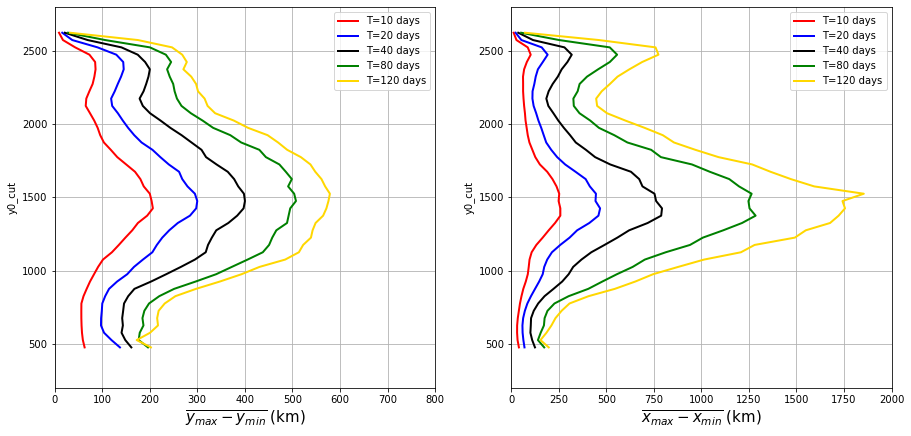

In [18]:
fig,axs = plt.subplots(1,2,figsize=(15,7))

for T,c in zip(ds_stats.keys(),colors):
    for var,lab,ax in zip(['ydiff','xdiff'],[r'$\overline{y_{max}-y_{min}}$ (km)',r'$\overline{x_{max}-x_{min}}$ (km)'],axs):
        ds_stats[T][var].plot(y='y0_cut',ax=ax,c=c,linewidth=2,label='T=%s days'%int(T))
        ax.set_xlabel(lab,fontsize=fontsize)
        ax.legend()
        ax.set_ylim(200,2800)
        ax.grid()
axs[0].set_xlim(0,800);axs[1].set_xlim(0,2000);

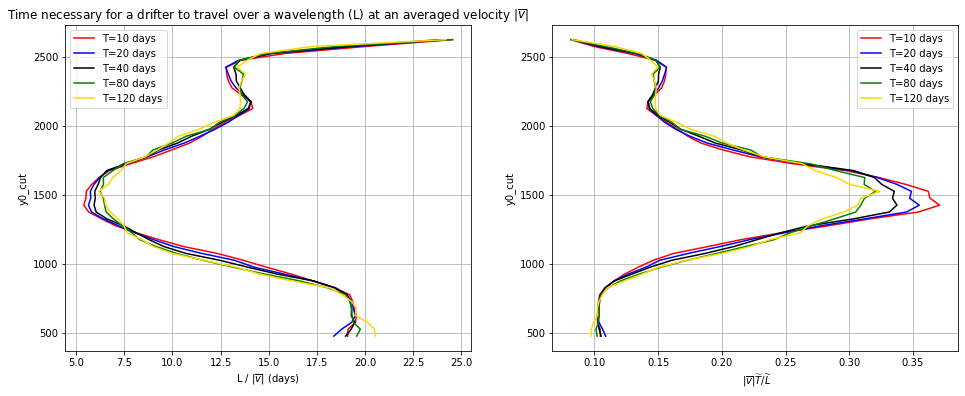

In [20]:
Lbc = 165
Tw = 2
fig, ax = plt.subplots(1,2,figsize=(16,6))
for T, c in zip(ds_stats.keys(),colors):
    (Lbc/(24*3600*ds_stats[T].dy*1e-3)).plot(ax=ax[0],y='y0_cut',c=c,label='T=%s days'%int(T))
ax[0].grid();ax[0].set_xlabel(r'L / $\vert\overline{v}\vert$ (days)')
ax[0].set_title(r'Time necessary for a drifter to travel over a wavelength (L) at an averaged velocity $\vert\overline{v}\vert$')
ax[0].legend()
#Tbc = (Lbc/(ds80_stats.dy*1e-3))/24*3600
#Tbc2 = (Lbc/(2*ds80_stats.dy*1e-3))/24*3600

for T, c in zip(ds_stats.keys(),colors):
    (Tw*(24*3600*ds_stats[T].dy*1e-3)/Lbc).plot(ax=ax[1],y='y0_cut',c=c,label='T=%s days'%int(T))
ax[1].grid();ax[1].set_xlabel(r' $\vert\overline{v}\vert\widetilde{T}/\widetilde{L}$')
#ax.set_title(r'Time necessary for a drifter to travel over a wavelength (L) at an averaged velocity $\vert\overline{v}\vert$')
ax[1].legend()

### Autocorrelations T=40days

In [9]:
#path = '/home/datawork-lops-osi/equinox/jetn/old/jet_cfg1_wp75_4km_1500a2000j_itide/diagnostics/' #datarmor
path = '/Users/zcaspar/codes/Diagnostics/'#local

In [28]:
corrE = {}
removed = ['avg1d','total']
for name,data in zip(removed,['ZC_Eulerian_corr_40avg1d.nc','ZC_Eulerian_corr_40total.nc']):
    corrE[name] = xr.open_dataset(path+data).rename({'lags':'lag'})
    for v in ['uu', 'vv']:
        corrE[name][v+'_normalized'] = corrE[name][v]/corrE[name][v].sel(lag=0)
    for v in ['uv']:#
        corrE[name][v+'_normalized'] = corrE[name][v]/np.sqrt(corrE[name]['uu'].sel(lag=0)*corrE[name]['vv'].sel(lag=0))

In [11]:
corrL = {}
removed = ['avg1d','total']
for name,data in zip(removed,
                     ['ZC_drifters_corr_40avg1d.nc','ZC_drifters_corr_40total.nc']):
    corrL[name] = xr.open_dataset(path+data)
    for v in ['uu', 'vv']:
        corrL[name][v+'_normalized'] = corrL[name][v]/corrL[name][v].sel(lag=0)
    for v in ['uv', 'vu']:
        corrL[name][v+'_normalized'] = corrL[name][v]/np.sqrt(corrL[name]['uu'].sel(lag=0)*corrL[name]['vv'].sel(lag=0))

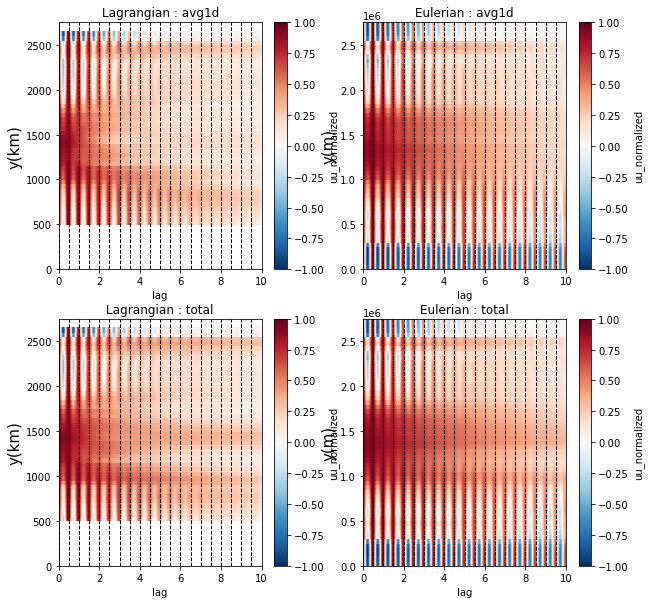

In [30]:
fig,ax = plt.subplots(2,2,figsize=(10,10))
for V,i in zip(['avg1d','total'],range(2)):
    corrL[V]['uu_normalized'].plot(ax=ax[i,0]);ax[i,0].set_ylabel('')
    corrE[V]['uu_normalized'].plot(ax=ax[i,1]);ax[i,1].set_ylabel('')
    [ax[i,0].axvline(x,linestyle='--',color='k',linewidth=1) for x in np.arange(0,10,0.5)]
    ax[i,0].set_title('Lagrangian : '+V);ax[i,0].set_ylabel('y(km)',fontsize=15)
    [ax[i,1].axvline(x,linestyle='--',color='k',linewidth=1) for x in np.arange(0,10,0.5)]
    ax[i,1].set_title('Eulerian : '+V);ax[i,1].set_ylabel('y(m)',fontsize=15)
    ax[i,1].set_xlim(0,10);ax[i,0].set_xlim(0,10)

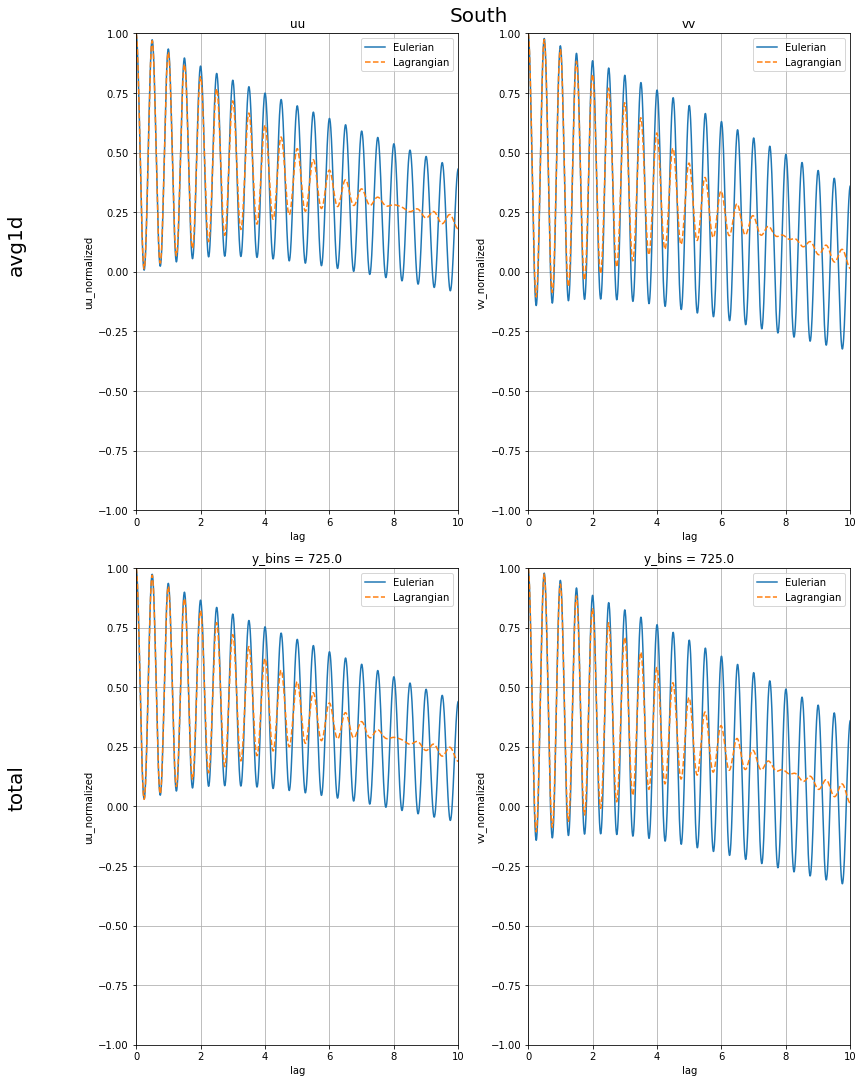

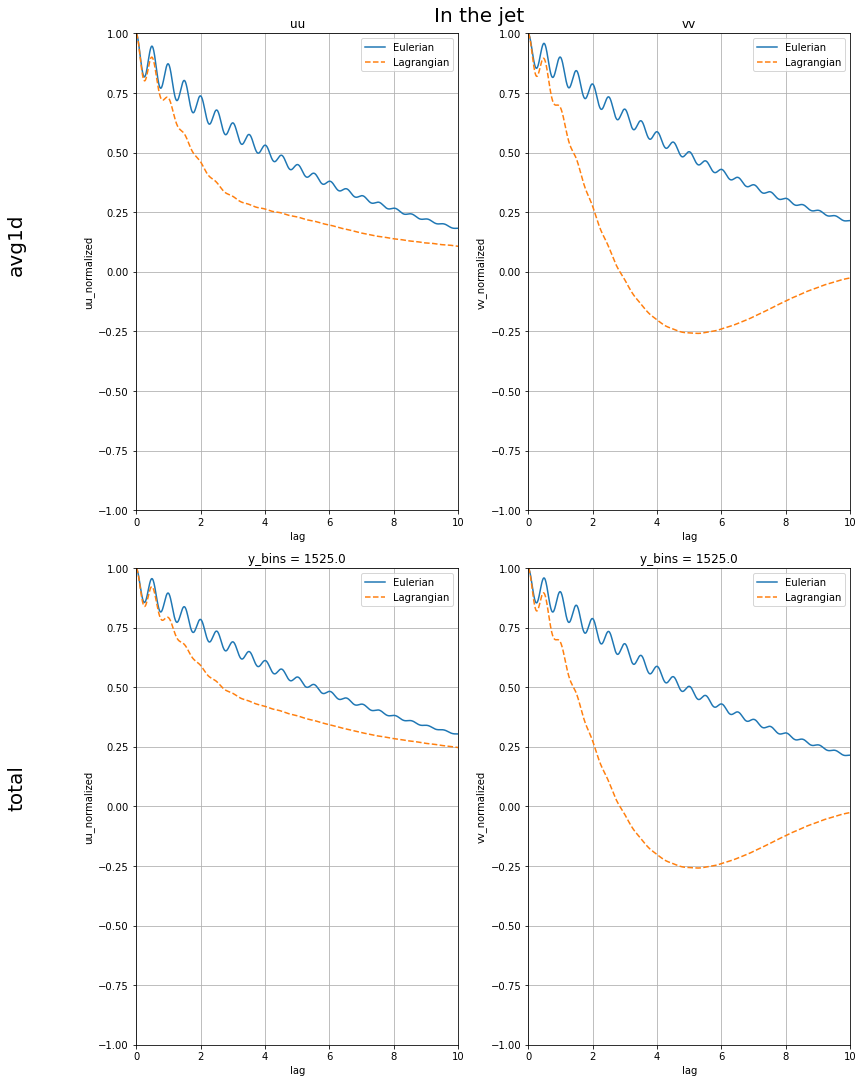

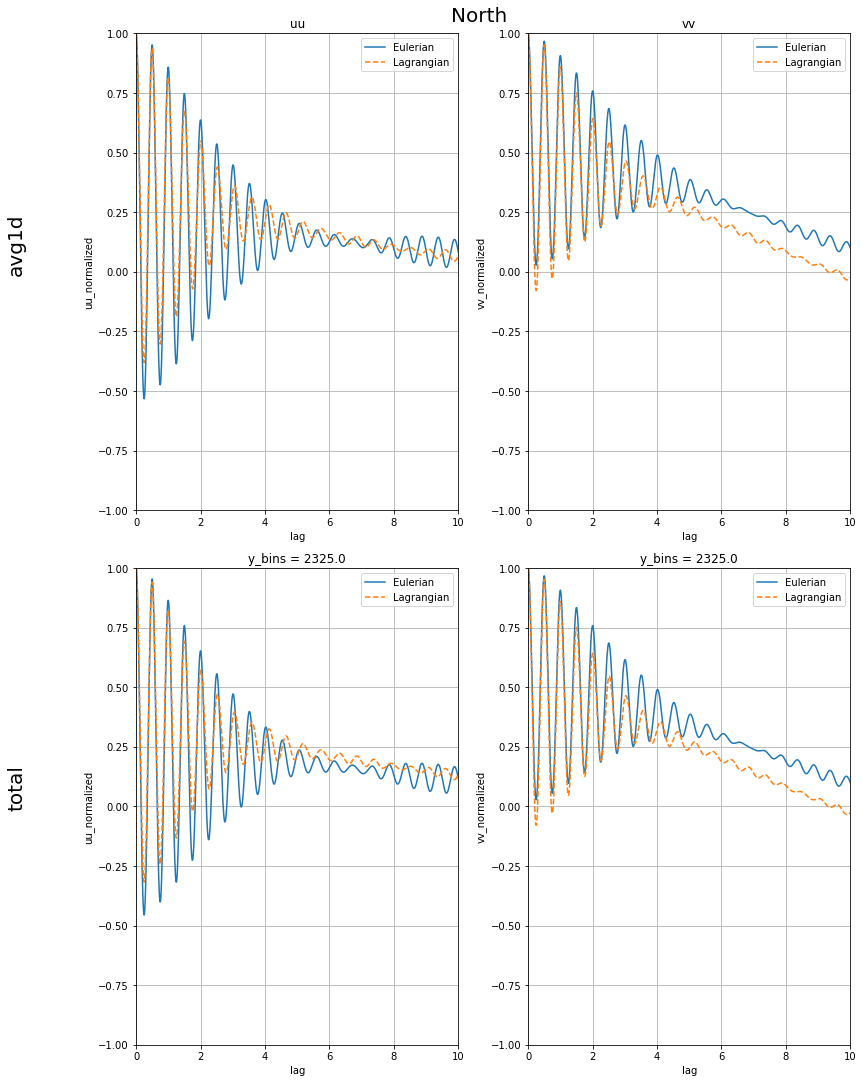

In [31]:
#Sections
Y=[700*1e3,1500*1e3,2300*1e3]
for y,title in zip(Y,['South','In the jet','North']):
    fig,axs = plt.subplots(len(removed),2,figsize=(12,15))
    for i,name in enumerate(removed):
        for V,ax in zip(['uu','vv'],axs[i,:]):
            corrE[name][V+'_normalized'].sel(y_bins=y,method='nearest').plot(ax=ax,label=('Eulerian'))
            corrL[name][V+'_normalized'].sel(y_bins=y*1e-3,method='nearest').plot(linestyle='--',ax=ax,label=('Lagrangian'))
            ax.set_xlim(0,10);ax.set_ylim(-1,1);ax.grid();ax.legend()
        axs[i,0].text(-4,0,name,fontsize=20,rotation=90)
    axs[0,0].set_title('uu');axs[0,1].set_title('vv')#;axs[0,2].set_title('uv');axs[0,3].set_title('vu')
    plt.suptitle(title,x=.55,y=1,fontsize=20)
    fig.tight_layout()

### Fit

Mettre figures résultats fit eulerién lagrangien avec intervalles de confiance (bootstrap)

$\widetilde{C} = \widetilde{X}cos(\omega\tau)e^{-\tau/\tilde{T}}$\
$\overline{C} = \overline{X}cos(\Omega\tau)e^{-\tau/\bar{T}}$\
$C = \widetilde{C}+\overline{C}$

In [3]:
om = 2 # tidal frequency (M2)
# Fast contribution
def Ctilde(t,Tt):
    return np.exp(-t/Tt)*np.cos(2*np.pi*om*t)#*np.cos(2*np.pi*nu*t)
#Slow contribution
def Cbar(t,Tb):
    return np.exp(-t/Tb)#*np.cos(2*np.pi*Om*t)
#Total formula
def C(t,Tt,Xtilde,Tb,Xbar):
    return Xbar*Cbar(t,Tb)+Xtilde*Ctilde(t,Tt)

In [4]:
def fit(t,y,myfunc,bounds,norm=False): 
    """Compute the best fit parameters found using scipy.optimize.curve_fit
        Parameters
        ----------
        t : timelag of the correlation function
        y : data to fit
        myfunc : function we want to fit to our data, y
        bounds : bounds of the parameters to fit 
        
        Returns
        ----------
        yfit : best fit
        params : parameters for which we obtain the best fit
        cov : covariance of params computed in scipy.optimize.curve_fit
        """
    sig = signature(myfunc)
    if norm:
        y = y/y.sel(lag=0)
    if np.isnan(y).any()==True:
        yfit = np.full_like(y,np.nan)
        params=np.full(len([V for V in sig.parameters.keys()][1:]),np.nan)
        cov = np.full((len([V for V in sig.parameters.keys()][1:]),len([V for V in sig.parameters.keys()][1:])),np.nan)
        yfit = xr.DataArray(np.full(y.lag.size,np.nan))
    else : 
        params,cov = scipy.optimize.curve_fit(myfunc,t,y,bounds=bounds)#,sigma=weights,absolute_sigma=True)
        yfit = myfunc(t,*[p for p in params])
    out = xr.Dataset({'params':(['ybin','param'],np.expand_dims(params, axis=0)),
                      'fitted':(['ybin','lags'],np.expand_dims(yfit.values,axis=0))},
                     coords={'ybin':np.array([y.y_bins.values]),'param':[V for V in sig.parameters.keys()][1:],
                             'lags':y.lag.values})
    return out#yfit,params,cov

In [54]:
from inspect import signature
import scipy


# Parameters
myfunc = C #function to use for the fit
bounds = ((1,0,0,0),np.inf) # bounds for the fit to avoid non physical results

In [55]:
out_combL_avg,out_combE_avg = {},{}
for V in ['uu','vv'] :
    out_combL_avg[V] = xr.concat([fit(corrL['avg1d'][V].lag,corrL['avg1d'][V].sel(y_bins=Y,method='nearest'),
                              myfunc,bounds,False) for Y in corrL['avg1d'][V].y_bins],dim='ybin')
    out_combE_avg[V] = xr.concat([fit(corrE['avg1d'][V].lag,corrE['avg1d'][V].sel(y_bins=Y,method='nearest'),
                              myfunc,bounds,False) for Y in corrE['avg1d'][V].y_bins],dim='ybin')

In [56]:
for V in ['uu','vv'] :
    out_combE_avg[V] = out_combE_avg[V].assign_coords({'ybin':out_combE_avg[V].ybin.values*1e-3})

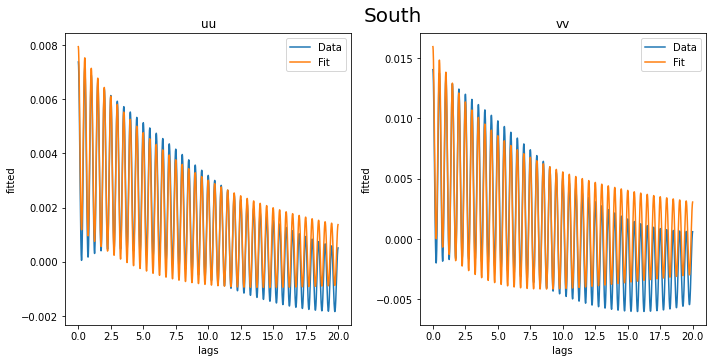

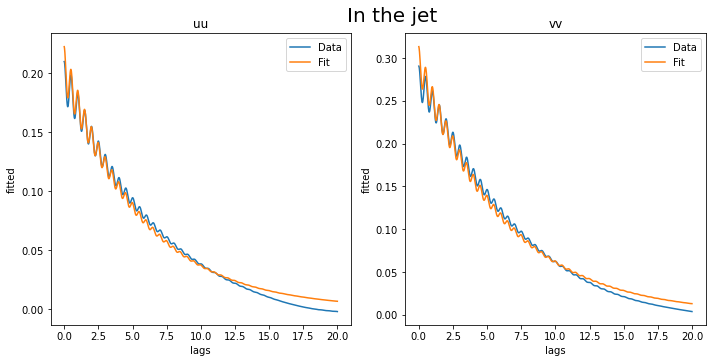

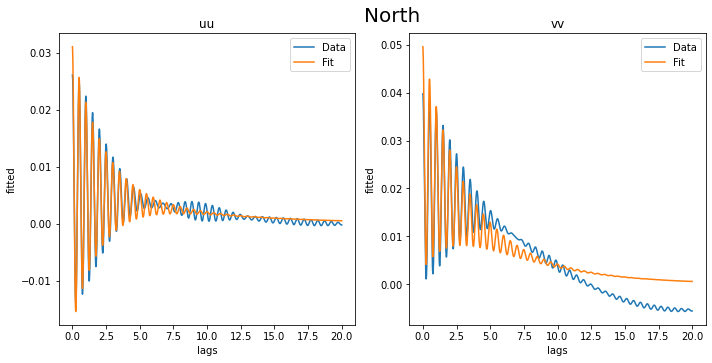

In [57]:
#Sections
Y=[700,1500,2300]
for y,title in zip(Y,['South','In the jet','North']):
    fig,axs = plt.subplots(1,2,figsize=(10,5))
    for V,ax in zip(['uu','vv'],axs[:]):
        corrE['avg1d'][V].sel(y_bins=y*1e3,method='nearest').plot(ax=ax,label=('Data'))
        out_combE_avg[V].fitted.sel(ybin=y,method='nearest').plot(ax=ax,label=('Fit'))
        
        #out_combL_avg[V].fitted.sel(ybin=y*1e-3,method='nearest').plot(linestyle='--',ax=ax,label=('Lagrangian'))
        #ax.set_xlim(0,10);ax.set_ylim(-1,1);ax.grid();ax.legend()
        ax.legend()
    axs[0].set_title('uu');axs[1].set_title('vv')#;axs[0,2].set_title('uv');axs[0,3].set_title('vu')
    plt.suptitle(title,x=.55,y=1,fontsize=20)
    fig.tight_layout()

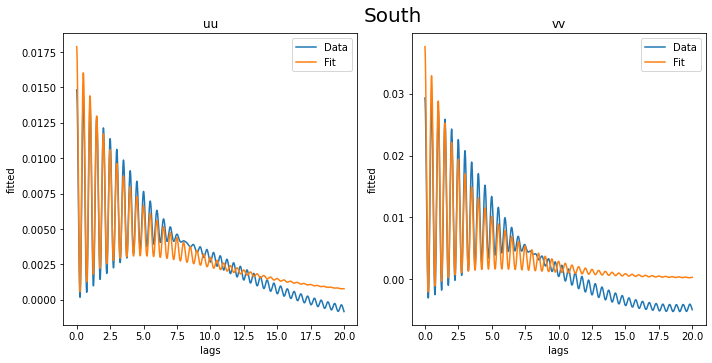

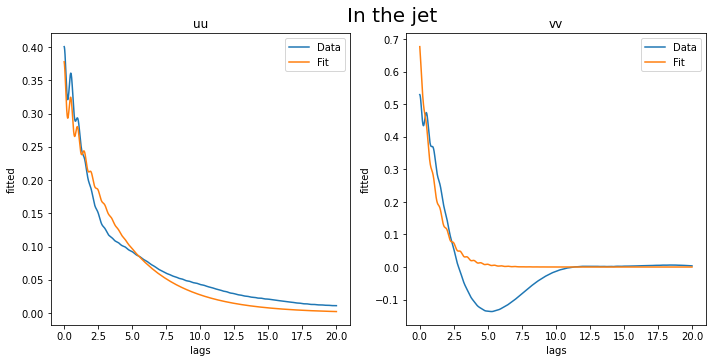

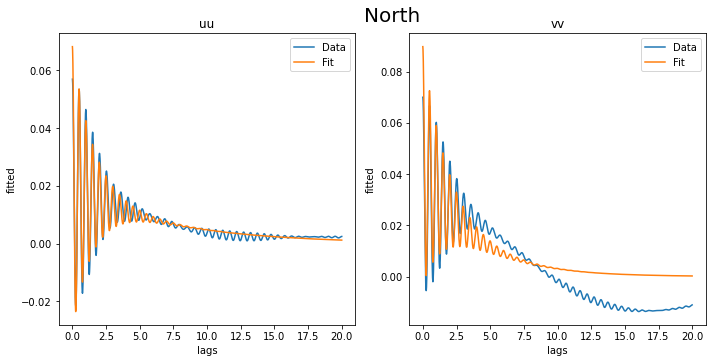

In [58]:
#Sections
Y=[700,1500,2300]
for y,title in zip(Y,['South','In the jet','North']):
    fig,axs = plt.subplots(1,2,figsize=(10,5))
    for V,ax in zip(['uu','vv'],axs[:]):
        corrL['avg1d'][V].sel(y_bins=y,method='nearest').plot(ax=ax,label=('Data'))
        out_combL_avg[V].fitted.sel(ybin=y,method='nearest').plot(ax=ax,label=('Fit'))
        
        #out_combL_avg[V].fitted.sel(ybin=y*1e-3,method='nearest').plot(linestyle='--',ax=ax,label=('Lagrangian'))
        #ax.set_xlim(0,10);ax.set_ylim(-1,1);ax.grid();ax.legend()
        ax.legend()
    axs[0].set_title('uu');axs[1].set_title('vv')#;axs[0,2].set_title('uv');axs[0,3].set_title('vu')
    plt.suptitle(title,x=.55,y=1,fontsize=20)
    fig.tight_layout()

In [21]:
cluster.close()